<a href="https://colab.research.google.com/github/kritika-ghosh/aviationDamage/blob/main/add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load your data
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(file_name, encoding='latin1')

Saving AviationData.csv to AviationData.csv


/tmp/ipython-input-2396420263.py:5: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, encoding='latin1')


Saving AviationData.csv to AviationData (1).csv


/tmp/ipython-input-2396420263.py:5: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, encoding='latin1')


In [ ]:
# View data types
print(df.dtypes)

# View number of unique values in each column
print(df.nunique())


Event.Id                   object
Investigation.Type         object
Accident.Number            object
Event.Date                 object
Location                   object
Country                    object
Latitude                   object
Longitude                  object
Airport.Code               object
Airport.Name               object
Injury.Severity            object
Aircraft.damage            object
Aircraft.Category          object
Registration.Number        object
Make                       object
Model                      object
Amateur.Built              object
Number.of.Engines         float64
Engine.Type                object
FAR.Description            object
Schedule                   object
Purpose.of.flight          object
Air.carrier                object
Total.Fatal.Injuries      float64
Total.Serious.Injuries    float64
Total.Minor.Injuries      float64
Total.Uninjured           float64
Weather.Condition          object
Broad.phase.of.flight      object
Report.Status 

In [ ]:
with pd.option_context('future.no_silent_downcasting', True):
    df['Aircraft.damage'] = df['Aircraft.damage'].replace({
        'Destroyed': 3, 'Substantial': 2, 'Minor': 1,
        'Unknown': 0, 'unknown': 0, np.nan: 0
    }).astype(int)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

df_encoded = df.copy()

for col in df.columns:
    if df[col].dtype == 'object':
        unique_vals = df[col].nunique()
        if unique_vals <= 30:
            # One-Hot Encode
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
        else:
            # Frequency encode
            freq_map = df[col].value_counts(normalize=True)
            df_encoded[col + '_freq'] = df[col].map(freq_map)

# Drop original categorical columns
df_encoded = df_encoded.drop(columns=[col for col in df.columns if df[col].dtype == 'object'])


Top correlated features:
 Investigation.Type_Incident          0.534264
Schedule_SCHD                        0.383744
Total.Uninjured                      0.336375
Injury.Severity_freq                 0.289260
Engine.Type_Turbo Fan                0.277247
Engine.Type_Reciprocating            0.256633
Number.of.Engines                    0.193361
Broad.phase.of.flight_Maneuvering    0.170028
Purpose.of.flight_Personal           0.153640
FAR.Description_freq                 0.139867
Country_freq                         0.124123
Total.Fatal.Injuries                 0.118659
Publication.Date_freq                0.116869
Make_freq                            0.113767
Report.Status_freq                   0.112907
Name: Aircraft.damage, dtype: float64


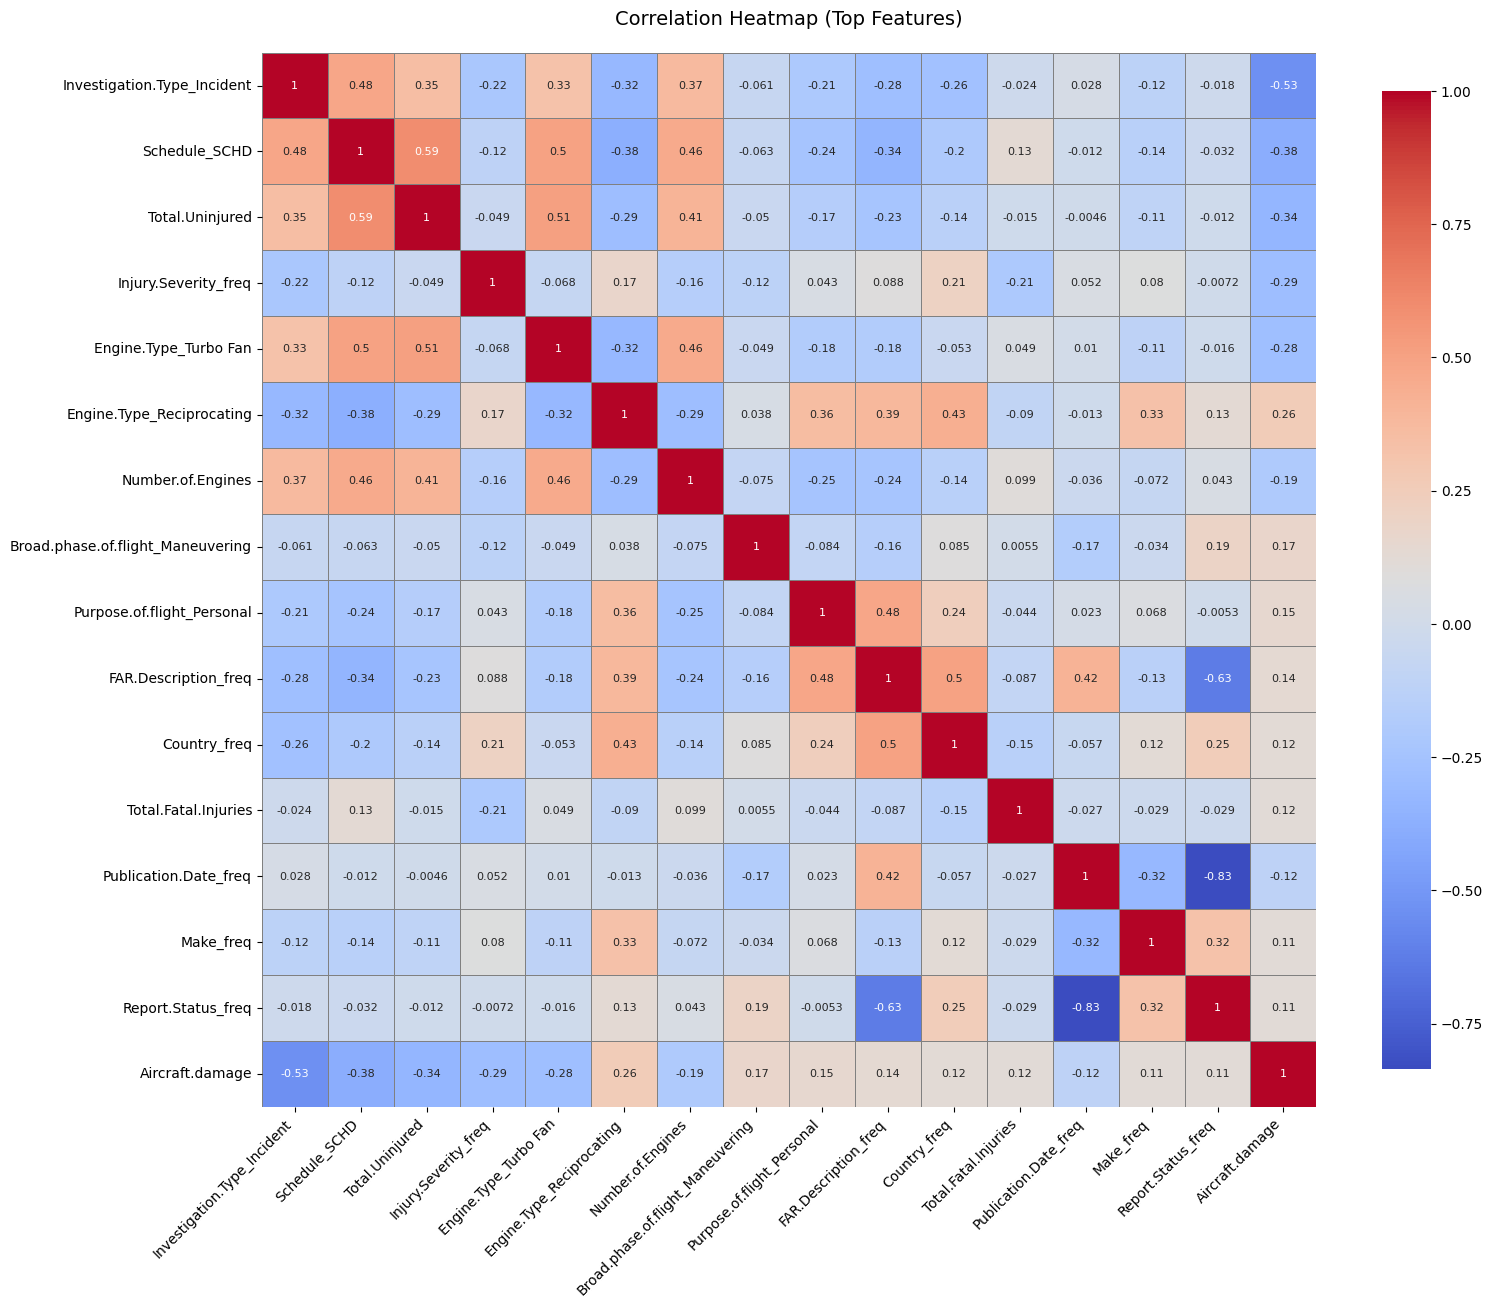

In [ ]:
# Correlation with target only
corr = df_encoded.corr(numeric_only=True)
target_corr = corr['Aircraft.damage'].drop('Aircraft.damage')

# Sort features by correlation with target
top_features = target_corr.abs().sort_values(ascending=False).head(15)
print("Top correlated features:\n", top_features)

# Plot heatmap of top correlated features
sns.heatmap(df_encoded[top_features.index.tolist() + ['Aircraft.damage']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Top Features)")
plt.show()


In [ ]:
print(top_features)

Investigation.Type_Incident          0.534264
Schedule_SCHD                        0.383744
Total.Uninjured                      0.336375
Injury.Severity_freq                 0.289260
Engine.Type_Turbo Fan                0.277247
Engine.Type_Reciprocating            0.256633
Number.of.Engines                    0.193361
Broad.phase.of.flight_Maneuvering    0.170028
Purpose.of.flight_Personal           0.153640
FAR.Description_freq                 0.139867
Country_freq                         0.124123
Total.Fatal.Injuries                 0.118659
Publication.Date_freq                0.116869
Make_freq                            0.113767
Report.Status_freq                   0.112907
Name: Aircraft.damage, dtype: float64


In [ ]:
features = [
    'Investigation.Type',
    'Schedule',
    'Total.Uninjured',
    'Injury.Severity',
    'Engine.Type',
    'Aircraft.damage'
]

df = df[features].replace(['unknown', 'Unknown', 'UNK', '', 'empty', 'Empty'], np.nan)
df.dropna(subset=features, inplace=True)

In [ ]:
# Binary encode Investigation.Type
df['Investigation.Type_Incident'] = (df['Investigation.Type'].str.lower() == 'incident').astype(int)

# Binary encode Schedule
df['Schedule_SCHD'] = (df['Schedule'].str.upper() == 'SCHD').astype(int)

# Clean Total.Uninjured (some values may be "2(1)", or text)
df['Total.Uninjured'] = pd.to_numeric(df['Total.Uninjured'], errors='coerce')
df.dropna(subset=['Total.Uninjured'], inplace=True)

# Frequency encode Injury.Severity
injury_counts = df['Injury.Severity'].value_counts(normalize=True)
df['Injury.Severity_freq'] = df['Injury.Severity'].map(injury_counts)

# Binary encode Engine.Type
df['Engine.Type_Turbo Fan'] = (df['Engine.Type'].str.lower() == 'turbo fan').astype(int)

# Clean target
damage_mapping = {
    'Destroyed': 3,
    'Substantial': 2,
    'Minor': 1,
    'Unknown': 0,
    'unknown': 0,
    np.nan: 0
}
df['Aircraft.damage'] = df['Aircraft.damage'].replace(damage_mapping).astype(int)

In [ ]:
selected_features = [
    'Investigation.Type_Incident',
    'Schedule_SCHD',
    'Total.Uninjured',
    'Injury.Severity_freq',
    'Engine.Type_Turbo Fan'
]
X = df[selected_features]
y = df['Aircraft.damage']

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(
    n_estimators=200,
    loss='log_loss',
    max_depth=5,
    random_state=42,
    verbose=1
)
model.fit(X_resampled, y_resampled)

      Iter       Train Loss   Remaining Time 
         1           1.2410           11.80s
         2           1.1315           10.78s
         3           1.0448           10.47s
         4           0.9752           10.46s
         5           0.9181           10.48s
         6           0.8703           10.57s
         7           0.8298           10.49s
         8           0.7965           10.36s
         9           0.7677           10.21s
        10           0.7434           10.23s
        20           0.6237            9.24s
        30           0.5799            8.70s
        40           0.5576            8.06s
        50           0.5428            7.56s
        60           0.5326            7.15s
        70           0.5235            7.20s
        80           0.5151            7.04s
        90           0.5086            6.44s
       100           0.5022            5.77s
       200           0.4604            0.00s


GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42,
                           verbose=1)

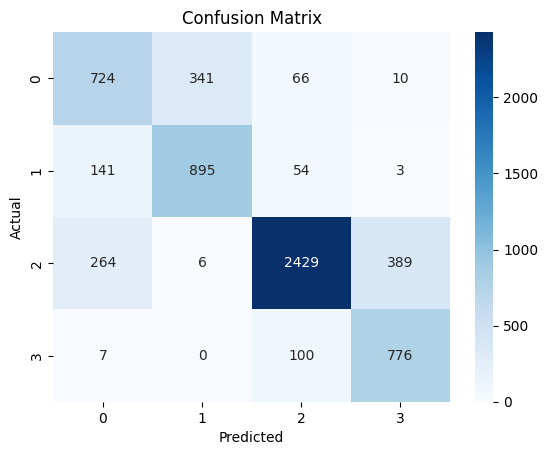

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1141
           1       0.72      0.82      0.77      1093
           2       0.92      0.79      0.85      3088
           3       0.66      0.88      0.75       883

    accuracy                           0.78      6205
   macro avg       0.73      0.78      0.75      6205
weighted avg       0.79      0.78      0.78      6205



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Predict on original (unresampled) data to simulate real-world inference
y_pred = model.predict(X)

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y, y_pred))

In [ ]:
df = df[df['Aircraft.damage'] != 0]  # Drop all rows where damage is 0 (Unknown)

Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.89      0.90       219
           2       0.91      0.83      0.87       618
           3       0.64      0.84      0.72       176

    accuracy                           0.85      1013
   macro avg       0.82      0.85      0.83      1013
weighted avg       0.86      0.85      0.85      1013

Confusion Matrix:
 [[194  25   0]
 [ 18 516  84]
 [  2  27 147]]


In [ ]:
features = [
    'Investigation.Type', 'Schedule', 'Total.Uninjured',
    'Injury.Severity', 'Engine.Type'
]

In [ ]:
# Filter out unwanted values
for col in features:
    df = df[~df[col].isin(['unknown', 'Unknown', 'empty', 'Empty'])]
    df = df[df[col].notna()]

In [ ]:
# =Preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [ ]:
# Feature Engineering
df['Injury.Severity_freq'] = df['Injury.Severity'].map(df['Injury.Severity'].value_counts())
df['Investigation.Type_Incident'] = (df['Investigation.Type'] == 'Incident').astype(int)
df['Schedule_SCHD'] = (df['Schedule'] == 'SCHD').astype(int)
df['Engine.Type_Turbo Fan'] = (df['Engine.Type'] == 'Turbo Fan').astype(int)



In [ ]:
# Select features
X = df[[
    'Investigation.Type_Incident',
    'Schedule_SCHD',
    'Total.Uninjured',
    'Injury.Severity_freq',
    'Engine.Type_Turbo Fan'
]]

y = df['Aircraft.damage']  # Now only labels 1, 2, 3


In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [ ]:
# Handle Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



In [ ]:
# Train the Model
model = GradientBoostingClassifier(
    n_estimators=200,
    loss='log_loss',
    max_depth=5,
    random_state=42
)
model.fit(X_resampled, y_resampled)



In [ ]:
# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, 'aircraft_damage_model.pkl')
files.download('aircraft_damage_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>